In [1]:
#!pip install tqdm

In [88]:
# import necessary packages
%matplotlib inline
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import earthpy as et
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

In [89]:
%matplotlib inline

# LA County Shapefile

In [217]:
# Graph neighbors of a region
def graph_neighbors(df, region):
    df['plot_col'] = 0
    df.plot_col = df.plot_col.mask(df['region'] == region, 1)
    temp_n = df[df.region == region].neighbors.values[0].split(',')
    temp_n = [n.strip() for n in temp_n]
    for n in temp_n:
        df.plot_col = df.plot_col.mask(df['region'] == n, 2)
    df.plot(column='plot_col', figsize=(10,10))
    
# Graph region
def graph_region(df, region):
    df['plot_col'] = 0
    df.plot_col = df.plot_col.mask(df['region'] == region, 1)

    df.plot(column='plot_col', figsize=(10,10), alpha=0.5)

In [218]:
# Load the shape file from github
# !wget -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/shape/la_shape.zip
# !unzip -nq la_shape -d shape

In [219]:
# la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_filtered = la_shapes.rename(columns={'name':'region'})
la_filtered["neighbors"] = None  # add NEIGHBORS column
la_filtered["plot_col"] = 0 # Column used to graph neighbors
la_filtered = la_filtered[['region','geometry','neighbors','plot_col']]
la_filtered.head()

,region,geometry,neighbors,plot_col
0,Acton,"POLYGON ((-118.20262 34.53899, -118.18947 34.5...",None,0
1,Adams-Normandie,"POLYGON ((-118.30901 34.03741, -118.30041 34.0...",None,0
2,Agoura Hills,"POLYGON ((-118.76193 34.16820, -118.72632 34.1...",None,0
3,Agua Dulce,"POLYGON ((-118.25468 34.55830, -118.25551 34.5...",None,0
4,Alhambra,"POLYGON ((-118.12175 34.10504, -118.11687 34.1...",None,0


## Get bordering regions

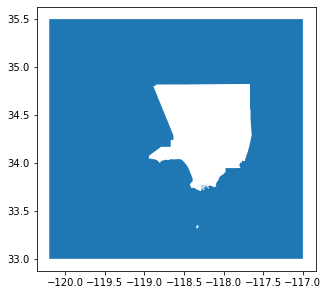

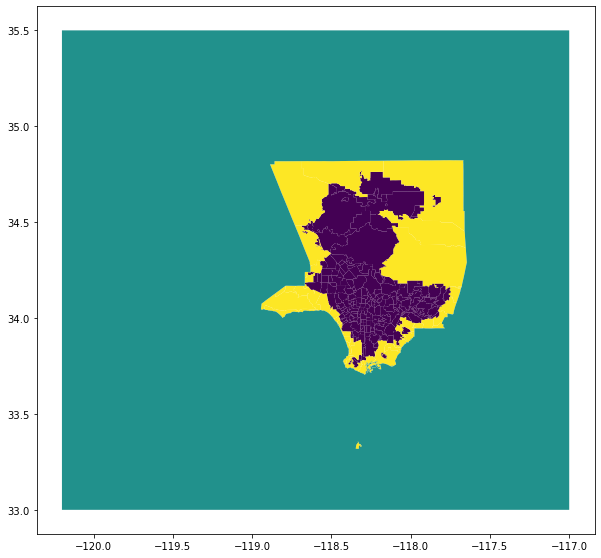

In [220]:
# Create a polygon that covers the entire la county region
cover = gpd.GeoSeries(Polygon([(-120.2,35.5), (-120.2,33), (-117,33), (-117,35.5)])).set_crs(epsg=4269)
# Remove Catalina Island since it is an island which has no neighbors
la_noisland = la_filtered[la_filtered['region']!='Unincorporated Catalina Island']
# Remove small holes within the la county unary union polygon
no_holes = MultiPolygon(Polygon(p.exterior) for p in la_noisland.geometry.unary_union)
no_holes_series = gpd.GeoSeries(no_holes).set_crs(epsg=4269)
# Subtract la county from the covering polygon
diff = gpd.GeoSeries.difference(cover, no_holes_series)
# We can find the cities that are touching 'diff' to locate border cities
diff.plot(figsize=(5,5))
# Get neighbors of diff to obtain bordered regions
border_regions = la_filtered[~la_filtered.geometry.disjoint(diff[0])].region.tolist()
la_filtered.loc[len(la_filtered)] = ["COVER", diff[0], ", ".join(border_regions), 0]
graph_neighbors(la_filtered, 'COVER')
la_filtered = la_filtered[:-1]

## Get neighbors of each region

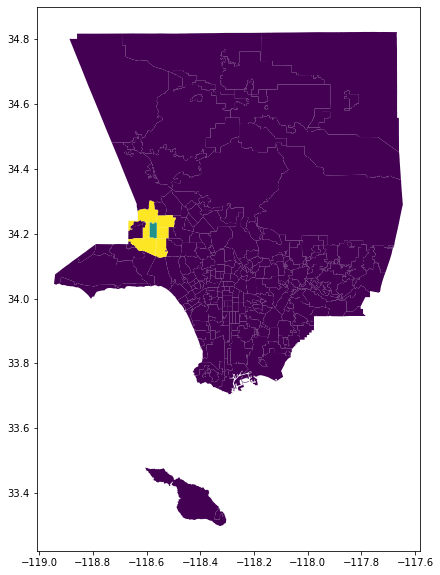

In [222]:
for index, row in la_filtered.iterrows():   
    # Get neighboring cities
    neighbors = la_filtered[~la_filtered.geometry.disjoint(row.geometry)].region.tolist()
    # Remove own name from list
    if row['region'] in neighbors:
        neighbors.remove(row['region'])
    la_filtered.at[index, "neighbors"] = ", ".join(neighbors)
graph_neighbors(la_filtered, 'Winnetka')
la_filtered = la_filtered[['region','neighbors','geometry']]

## Remove bordering regions

In [223]:
la_inner = la_filtered[~la_filtered['region'].isin(border_regions)]
la_inner.tail()

,region,neighbors,geometry
266,Whittier Narrows,"Avocado Heights, Industry, Montebello, Pico Ri...","POLYGON ((-118.06940 34.05292, -118.06872 34.0..."
267,Willowbrook,"Broadway-Manchester, Compton, Green Meadows, H...","POLYGON ((-118.23005 33.92809, -118.22803 33.9..."
269,Windsor Square,"Hancock Park, Koreatown, Larchmont","POLYGON ((-118.31371 34.07631, -118.31381 34.0..."
270,Winnetka,"Canoga Park, Chatsworth, Northridge, Reseda, T...","POLYGON ((-118.56221 34.23150, -118.56212 34.2..."
271,Woodland Hills,"Calabasas, Canoga Park, Hidden Hills, Pacific ...","POLYGON ((-118.57569 34.18822, -118.57362 34.1..."


## Remove neighbors of city which does not have covid data

In [233]:
!wget --directory-prefix=../data/covid -Nq https://raw.githubusercontent.com/ANRGUSC/lacounty_covid19_data/master/data/Covid-19.csv
covid_filename = '../data/covid/Covid-19.csv'

covid_df = pd.read_csv(covid_filename)
covid_unique_regions = pd.DataFrame(data=pd.unique(covid_df.Region),columns=['region'])
covid_df.head()

,Time Stamp,Region,Latitude,Longitude,Number of cases
0,03-16-2020,Alhambra,34.093042,-118.127060,2
1,03-16-2020,Arcadia,34.136208,-118.040150,1
2,03-16-2020,Beverly Hills,34.069650,-118.396306,1
3,03-16-2020,Boyle Heights,34.043689,-118.209768,5
4,03-16-2020,Carson,33.832204,-118.251755,1


In [31]:
# Get all regions that have data
# census_unique_regions = pd.DataFrame(data=pd.unique(census_data.name),columns=['region'])
# regions = pd.merge(covid_unique_regions, la_neighbors[['region']], on='region', how='inner')
# regions = pd.merge(regions, census_unique_regions, on='region', how='inner')['region'].values

In [240]:
check_df = la_neighbors.assign(InDf2=la_inner.region.isin(covid_unique_regions.region))
miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
miss_set = set(miss_arr)
len(miss_set)

73

In [242]:
for region in miss_arr:
    temp_n = la_inner[la_inner.region == region].neighbors.values[0].split(',')
    temp_n = set([n.strip() for n in temp_n])
    miss_set = miss_set | temp_n
len(miss_set)

198

In [ ]:
# check_df = covid_df.assign(InDf2=covid_df.Region.isin(la_neighbors.region))
# missing_arr = pd.unique(check_df[check_df['InDf2']==False]['Region'])
# missing_arr

# Aggregate Covid Data

In [10]:
census_data = pd.read_csv('../data/social_explorer_processed_data_only_percents.csv')
census_data.shape

(261, 168)

## Month aggregate

In [32]:
covid_df_month = covid_df[['Time Stamp', 'Region', 'Number of cases']]
covid_df_month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_month = covid_df_month.set_index('Time Stamp')
covid_df_month = covid_df_month.groupby([pd.Grouper(freq='M'), 'Region']).sum()
covid_df_month = covid_df_month.reset_index(level=['Time Stamp','Region']).rename(columns={'Time Stamp': 'month', 'Region':'region', 'Number of cases':'cases'})
covid_df_month.month = covid_df_month.month.dt.month
covid_df_month

<ipython-input-32-bfc1e52585cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])


,month,region,cases
0,3,Acton,0
1,3,Adams-Normandie,5
2,3,Agoura Hills,56
3,3,Alhambra,90
4,3,Alsace,0
...,...,...,...
1920,10,Willowbrook,2956
1921,10,Wilmington,21925
1922,10,Wilshire Center,13635
1923,10,Winnetka,15708


### Data w/o census

In [14]:
month_data_no_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_month.month)
# List of month case sums
covid_month_gp = covid_df_month.groupby('month').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last month since data for last month is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        # Get cases for current region
        region_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases, fill missing neighbor data with avg of other neighbors
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_month_gp[covid_month_gp['month'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get cases for next time_frame
        next_cases = covid_df_month.loc[(covid_df_month.month == time_frames[i+1]) & (covid_df_month.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])
        
        # Add data to numpy arr
        if len(month_data_no_census.shape) == 1:
            month_data_no_census = np.array([row_data])
        else:
            month_data_no_census = np.append(month_data_no_census, [row_data], axis=0)
month_data_no_census

array([[3.00000000e+00, 9.00000000e+01, 1.16000000e+02, 1.24070000e+04,
        5.52000000e+02],
       [3.00000000e+00, 7.10000000e+01, 5.50000000e+01, 1.24070000e+04,
        3.72000000e+02],
       [3.00000000e+00, 2.11000000e+02, 1.35840000e+03, 1.24070000e+04,
        1.82700000e+03],
       ...,
       [8.00000000e+00, 3.01590000e+04, 2.54997750e+05, 6.44468600e+06,
        3.37580000e+04],
       [8.00000000e+00, 7.30500000e+03, 2.07651600e+05, 6.44468600e+06,
        7.98900000e+03],
       [8.00000000e+00, 4.44410000e+04, 1.69757333e+05, 6.44468600e+06,
        5.14080000e+04]])

In [15]:
month_data_no_census.shape

(1110, 5)

In [19]:
month_data_with_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_month.month)
# List of month case sums
covid_month_gp = covid_df_month.groupby('month').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last month since data for last month is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        # Get cases for current region
        region_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases, fill missing neighbor data with avg of other neighbors
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_month_gp[covid_month_gp['month'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get census data
        census_row = census_data[census_data['name']==region].values[0][1:]
        row_data = np.append(row_data, census_row)
        
        # Get cases for next time_frame
        next_cases = covid_df_month.loc[(covid_df_month.month == time_frames[i+1]) & (covid_df_month.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])
        
        # Add data to numpy arr
        if len(month_data_with_census.shape) == 1:
            month_data_with_census = np.array([row_data])
        else:
            month_data_with_census = np.append(month_data_with_census, [row_data], axis=0)
month_data_with_census = month_data_with_census.astype(float)
month_data_with_census

array([[3.00000000e+00, 9.00000000e+01, 1.16000000e+02, ...,
        2.21225405e+00, 1.25055221e+00, 5.52000000e+02],
       [3.00000000e+00, 7.10000000e+01, 5.50000000e+01, ...,
        2.24484182e+00, 2.20632737e+00, 3.72000000e+02],
       [3.00000000e+00, 2.11000000e+02, 1.35840000e+03, ...,
        1.83572923e+00, 6.07410410e-02, 1.82700000e+03],
       ...,
       [8.00000000e+00, 3.01590000e+04, 2.54997750e+05, ...,
        1.72302112e+00, 8.23940925e-01, 3.37580000e+04],
       [8.00000000e+00, 7.30500000e+03, 2.07651600e+05, ...,
        7.89447387e-01, 4.89657240e-01, 7.98900000e+03],
       [8.00000000e+00, 4.44410000e+04, 1.69757333e+05, ...,
        8.83993504e+00, 6.58758738e+00, 5.14080000e+04]])

In [20]:
month_data_with_census.shape

(1110, 172)

In [21]:
np.save('../data/covid/covid_month_no_census', month_data_no_census)
np.save('../data/covid/covid_month_with_census', month_data_with_census)

### Week Aggregate

In [21]:
covid_df_week = covid_df[['Time Stamp', 'Region', 'Number of cases']]
covid_df_week['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_week = covid_df_week.set_index('Time Stamp')
covid_df_week = covid_df_week.groupby([pd.Grouper(freq='W'), 'Region']).sum()
covid_df_week = covid_df_week.reset_index(level=['Time Stamp','Region']).rename(columns={'Time Stamp': 'week', 'Region':'region', 'Number of cases':'cases'})
covid_df_week.week = covid_df_week.week.dt.week
covid_df_week

<ipython-input-21-45b2c6178f57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_week['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
<ipython-input-21-45b2c6178f57>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  covid_df_week.week = covid_df_week.week.dt.week


,week,region,cases
0,12,Alhambra,15
1,12,Altadena,9
2,12,Arcadia,12
3,12,Athens,1
4,12,Baldwin Hills,9
...,...,...,...
7051,41,Willowbrook,1728
7052,41,Wilmington,12840
7053,41,Wilshire Center,7991
7054,41,Winnetka,9229


In [22]:
week_data_no_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_week.week)
# List of month case sums
covid_week_gp = covid_df_week.groupby('week').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_week.loc[(covid_df_week.week == time_frame) & (covid_df_week.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_month.loc[(covid_df_week.week == time_frame) & (covid_df_week.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors) ## All neighbor data missing, fill with region itself
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_week_gp[covid_week_gp['week'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get cases for next time_frame
        next_cases = covid_df_week.loc[(covid_df_week.week == time_frames[i+1]) & (covid_df_week.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])

        # Add data to numpy arr
        if len(week_data_no_census.shape) == 1:
            week_data_no_census = np.array([row_data])
        else:
            week_data_no_census = np.append(week_data_no_census, [row_data], axis=0)
week_data_no_census

array([[1.20000000e+01, 1.50000000e+01, 0.00000000e+00, 1.29500000e+03,
        5.10000000e+01],
       [1.20000000e+01, 1.20000000e+01, 1.20000000e+02, 1.29500000e+03,
        4.00000000e+01],
       [1.20000000e+01, 3.00000000e+01, 1.46933333e+03, 1.29500000e+03,
        1.18000000e+02],
       ...,
       [3.90000000e+01, 8.07600000e+03, 5.65320000e+04, 1.72815000e+06,
        8.29000000e+03],
       [3.90000000e+01, 1.94400000e+03, 1.16640000e+04, 1.72815000e+06,
        2.00600000e+03],
       [3.90000000e+01, 1.23280000e+04, 4.93120000e+04, 1.72815000e+06,
        1.25980000e+04]])

In [23]:
week_data_no_census.shape

(5180, 5)

In [24]:
week_data_with_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_week.week)
# List of month case sums
covid_week_gp = covid_df_week.groupby('week').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_week.loc[(covid_df_week.week == time_frame) & (covid_df_week.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_month.loc[(covid_df_week.week == time_frame) & (covid_df_week.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors) ## All neighbor data missing, fill with region itself
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_week_gp[covid_week_gp['week'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get census data
        census_row = census_data[census_data['name']==region].values[0][1:]
        row_data = np.append(row_data, census_row)
        
        # Get cases for next time_frame
        next_cases = covid_df_week.loc[(covid_df_week.week == time_frames[i+1]) & (covid_df_week.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])

        # Add data to numpy arr
        if len(week_data_with_census.shape) == 1:
            week_data_with_census = np.array([row_data])
        else:
            week_data_with_census = np.append(week_data_with_census, [row_data], axis=0)
week_data_with_census

array([[12.0, 15.0, 0.0, ..., 2.212254052, 1.250552214, 51],
       [12, 12, 120, ..., 2.244841816, 2.206327373, 40],
       [12.0, 30.0, 1469.3333333333335, ..., 1.83572923,
        0.060741040999999996, 118],
       ...,
       [39, 8076, 56532, ..., 1.7230211169999998, 0.823940925, 8290],
       [39, 1944, 11664, ..., 0.7894473870000001, 0.48965724, 2006],
       [39, 12328, 49312, ..., 8.839935042, 6.587587376, 12598]],
      dtype=object)

In [25]:
week_data_with_census.shape

(5180, 172)

In [26]:
np.save('../data/covid/covid_week_no_census', week_data_no_census)
np.save('../data/covid/covid_week_with_census', week_data_with_census)

### 3-month aggregate

In [27]:
covid_df_3month = covid_df[['Time Stamp', 'Region', 'Number of cases']]
covid_df_3month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_3month = covid_df_3month.set_index('Time Stamp')
covid_df_3month = covid_df_3month.groupby([pd.Grouper(freq='3M'), 'Region']).sum()
covid_df_3month = covid_df_3month.reset_index(level=['Time Stamp','Region']).rename(columns={'Time Stamp': 'month', 'Region':'region', 'Number of cases':'cases'})
covid_df_3month.month = covid_df_3month.month.dt.month
covid_df_3month


<ipython-input-27-84e9f6ee84a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_3month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])


,month,region,cases
0,3,Acton,0
1,3,Adams-Normandie,5
2,3,Agoura Hills,56
3,3,Alhambra,90
4,3,Alsace,0
...,...,...,...
960,12,Willowbrook,2708
961,12,Wilmington,20071
962,12,Wilshire Center,12475
963,12,Winnetka,14354


In [28]:
three_month_data_no_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_3month.month)
# List of month case sums
covid_3month_gp = covid_df_3month.groupby('month').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_3month.loc[(covid_df_3month.month == time_frame) & (covid_df_3month.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_3month.loc[(covid_df_3month.month == time_frame) & (covid_df_3month.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_3month_gp[covid_3month_gp['month'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get cases for next time_frame
        next_cases = covid_df_3month.loc[(covid_df_3month.month == time_frames[i+1]) & (covid_df_3month.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])

        # Add data to numpy arr
        if len(three_month_data_no_census.shape) == 1:
            three_month_data_no_census = np.array([row_data])
        else:
            three_month_data_no_census = np.append(three_month_data_no_census, [row_data], axis=0)
three_month_data_no_census

array([[3.0000000e+00, 9.0000000e+01, 1.1600000e+02, 1.2407000e+04,
        1.3784000e+04],
       [3.0000000e+00, 7.1000000e+01, 5.5000000e+01, 1.2407000e+04,
        5.7270000e+03],
       [3.0000000e+00, 2.1100000e+02, 1.3584000e+03, 1.2407000e+04,
        1.1006000e+04],
       ...,
       [6.0000000e+00, 2.0067000e+04, 1.9788825e+05, 3.5824330e+06,
        8.3992000e+04],
       [6.0000000e+00, 8.4880000e+03, 5.8767600e+04, 3.5824330e+06,
        2.1248000e+04],
       [6.0000000e+00, 1.8812000e+04, 1.4009200e+05, 3.5824330e+06,
        1.2318600e+05]])

In [29]:
three_month_data_no_census.shape

(370, 5)

In [30]:
three_month_data_with_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_3month.month)
# List of month case sums
covid_3month_gp = covid_df_3month.groupby('month').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_3month.loc[(covid_df_3month.month == time_frame) & (covid_df_3month.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_3month.loc[(covid_df_3month.month == time_frame) & (covid_df_3month.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_3month_gp[covid_3month_gp['month'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get census data
        census_row = census_data[census_data['name']==region].values[0][1:]
        row_data = np.append(row_data, census_row)
        
        # Get cases for next time_frame
        next_cases = covid_df_3month.loc[(covid_df_3month.month == time_frames[i+1]) & (covid_df_3month.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])

        # Add data to numpy arr
        if len(three_month_data_with_census.shape) == 1:
            three_month_data_with_census = np.array([row_data])
        else:
            three_month_data_with_census = np.append(three_month_data_with_census, [row_data], axis=0)
three_month_data_with_census

array([[3.0, 90.0, 116.0, ..., 2.212254052, 1.250552214, 13784],
       [3.0, 71.0, 55.0, ..., 2.244841816, 2.206327373, 5727],
       [3.0, 211.0, 1358.4, ..., 1.83572923, 0.060741040999999996, 11006],
       ...,
       [6.0, 20067.0, 197888.25, ..., 1.7230211169999998, 0.823940925,
        83992],
       [6.0, 8488.0, 58767.6, ..., 0.7894473870000001, 0.48965724, 21248],
       [6.0, 18812.0, 140092.0, ..., 8.839935042, 6.587587376, 123186]],
      dtype=object)

In [31]:
three_month_data_with_census.shape

(370, 172)

In [32]:
np.save('../data/covid/covid_3month_no_census', three_month_data_no_census)
np.save('../data/covid/covid_3month_with_census', three_month_data_with_census)

### Daily aggregate

In [33]:
covid_df_day = covid_df[['Time Stamp', 'Region', 'Number of cases']]
covid_df_day['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_day = covid_df_day.set_index('Time Stamp')
covid_df_day = covid_df_day.groupby([pd.Grouper(freq='D'), 'Region']).sum()
covid_df_day = covid_df_day.reset_index(level=['Time Stamp','Region']).rename(columns={'Time Stamp': 'day', 'Region':'region', 'Number of cases':'cases'})
covid_df_day.day = covid_df_day.day.dt.dayofyear
covid_df_day


<ipython-input-33-cb5b261e19bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_day['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])


,day,region,cases
0,76,Alhambra,2
1,76,Arcadia,1
2,76,Beverly Hills,1
3,76,Boyle Heights,5
4,76,Carson,1
...,...,...,...
48583,285,Willowbrook,248
48584,285,Wilmington,1851
48585,285,Wilshire Center,1152
48586,285,Winnetka,1349


In [34]:
day_data_no_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_day.day)
# List of month case sums
covid_day_gp = covid_df_day.groupby('day').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_day.loc[(covid_df_day.day == time_frame) & (covid_df_day.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_day.loc[(covid_df_day.day == time_frame) & (covid_df_day.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_day_gp[covid_day_gp['day'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get cases for next time_frame
        next_cases = covid_df_day.loc[(covid_df_day.day == time_frames[i+1]) & (covid_df_day.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])
        
        # Add data to numpy arr
        if len(day_data_no_census.shape) == 1:
            day_data_no_census = np.array([row_data])
        else:
            day_data_no_census = np.append(day_data_no_census, [row_data], axis=0)
day_data_no_census

array([[7.60000e+01, 2.00000e+00, 1.00000e+01, 6.00000e+01, 1.00000e+00],
       [7.60000e+01, 1.00000e+00, 1.00000e+01, 6.00000e+01, 1.00000e+00],
       [7.60000e+01, 1.00000e+00, 4.00000e+01, 6.00000e+01, 1.00000e+00],
       ...,
       [2.83000e+02, 1.20900e+03, 9.67750e+03, 2.50075e+05, 1.21200e+03],
       [2.83000e+02, 2.96000e+02, 7.85640e+03, 2.50075e+05, 2.96000e+02],
       [2.83000e+02, 1.84400e+03, 6.09600e+03, 2.50075e+05, 1.85100e+03]])

In [35]:
day_data_no_census.shape

(38480, 5)

In [ ]:
day_data_with_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_day.day)
# List of month case sums
covid_day_gp = covid_df_day.groupby('day').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_day.loc[(covid_df_day.day == time_frame) & (covid_df_day.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_day.loc[(covid_df_day.day == time_frame) & (covid_df_day.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_day_gp[covid_day_gp['day'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get census data
        census_row = census_data[census_data['name']==region].values[0][1:]
        row_data = np.append(row_data, census_row)
        
        # Get cases for next time_frame
        next_cases = covid_df_day.loc[(covid_df_day.day == time_frames[i+1]) & (covid_df_day.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])
        
        # Add data to numpy arr
        if len(day_data_with_census.shape) == 1:
            day_data_with_census = np.array([row_data])
        else:
            day_data_with_census = np.append(day_data_with_census, [row_data], axis=0)
day_data_with_census

In [ ]:
day_data_with_census.shape

In [ ]:
np.save('../data/covid/covid_day_no_census', day_data_no_census)
np.save('../data/covid/covid_day_with_census', day_data_with_census)

In [34]:
# covid_df_week.to_csv('../data/covid/covid_week.csv')
covid_df_month.to_csv('../data/covid/covid_month.csv')
# covid_df_3month.to_csv('../data/covid/covid_3months.csv')

In [12]:
la_neighbors[la_neighbors['region']=='Baldwin Hills/Crenshaw']

,region,neighbors
17,Baldwin Hills/Crenshaw,"Culver City, Jefferson Park, Ladera Heights, L..."


In [16]:
covid_df[covid_df['Region']=='Baldwin Hills']

,Time Stamp,Region,Latitude,Longitude,Number of cases
34,03-17-2020,Baldwin Hills,34.010989,-118.337071,1
75,03-18-2020,Baldwin Hills,34.010989,-118.337071,1
120,03-19-2020,Baldwin Hills,34.010989,-118.337071,1
191,03-20-2020,Baldwin Hills,34.010989,-118.337071,1
273,03-21-2020,Baldwin Hills,34.010989,-118.337071,2
...,...,...,...,...,...
49319,10-5-2020,Baldwin Hills,34.010989,-118.337071,627
49558,10-6-2020,Baldwin Hills,34.010989,-118.337071,628
49797,10-7-2020,Baldwin Hills,34.010989,-118.337071,634
50036,10-8-2020,Baldwin Hills,34.010989,-118.337071,636


In [ ]:
region_map = {
    'Baldwin Hills/Crenshaw':'Baldwin Hills',
    'Unincorporated Santa Monica Mountains':'Santa Monica Mountains',
    'Mid-Wilshire':'Wilshire Center',
    'Exposition Park':'Exposition',
    
}

In [74]:
from shapely.geometry import Point, Polygon
def find_la_region(covid_region):
    polys = la_neighbors['geometry']
    lat = covid_df[covid_df['Region']==covid_region].iloc[0,:][2]
    lng = covid_df[covid_df['Region']==covid_region].iloc[0,:][3]
#     print(lat, lng)
    return (la_neighbors[polys.contains(Point(lng, lat))], lat, lng)

In [57]:
find_la_region('Santa Monica Mountains')

34.031132 -118.261507


,region,neighbors,geometry
60,Downtown,"Boyle Heights, Central-Alameda, Chinatown, Ech...","POLYGON ((-118.24021 34.05871, -118.23951 34.0..."


In [58]:
find_la_region('Pico')

34.0406717 -118.2661915


,region,neighbors,geometry
60,Downtown,"Boyle Heights, Central-Alameda, Chinatown, Ech...","POLYGON ((-118.24021 34.05871, -118.23951 34.0..."


In [66]:
find_la_region('Exposition').shape

34.013653999999995 -118.2872106


(1, 3)

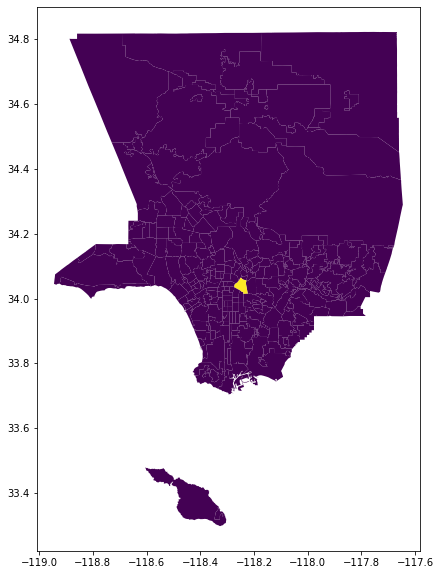

In [77]:
graph_region(la_neighbors, 'Downtown')

In [ ]:
cleaned_region_map = {
    'Downtown': ['City', 'Melrose', 'Temple', 'Pico']
}
wrong_map = ['Santa Monica Mountains', 'Melrose', '']

In [75]:
from collections import defaultdict

la_to_covid_map = defaultdict(list)

for covid_c in missing_arr:
    data = find_la_region(covid_c)
    if data[0].shape[0] == 0:
        continue
    la_to_covid_map[data[0].iloc[0,0]].append({covid_c:(data[1], data[2])})
la_to_covid_map

defaultdict(list,
            {'Downtown': [{'City': (34.0536909, -118.2427666)},
              {'Melrose': (34.0536909, -118.2427666)},
              {'Santa Monica Mountains': (34.031132, -118.261507)},
              {'Temple': (34.0536909, -118.2427666)},
              {'Pico': (34.0406717, -118.2661915)},
              {'Wholesale District': (34.0365749, -118.2354342)},
              {'Brookside': (34.0536909, -118.2427666)},
              {'Central': (34.0536909, -118.2427666)},
              {'Little Tokyo': (34.04821679999999, -118.2411814)},
              {'Temple-Beaudry': (34.062884600000004, -118.2512529)}],
             'Silver Lake': [{'Silverlake': (34.092941, -118.2697155)}],
             'Vernon': [{'West Vernon': (34.007135, -118.22525)},
              {'Vernon Central': (34.007135, -118.22525)}],
             'Baldwin Hills/Crenshaw': [{'Baldwin Hills': (34.01098870000001,
                -118.3370709)}],
             'Century City': [{'Century Palms/Cove': (34.062844